# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [4]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

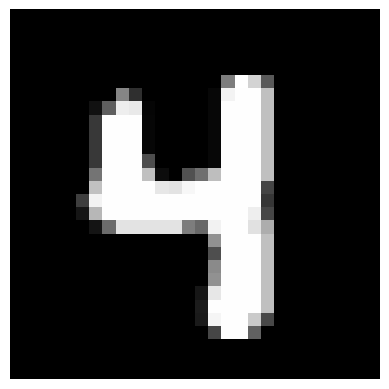

In [5]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [6]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [16]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ###
    ### Your code goes here        
    
    for label in range(0,k):
        indices = (y == label)
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1)
        pi[label] = float(sum(indices))/float(len(y))
    
    # Halt and return parameters
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

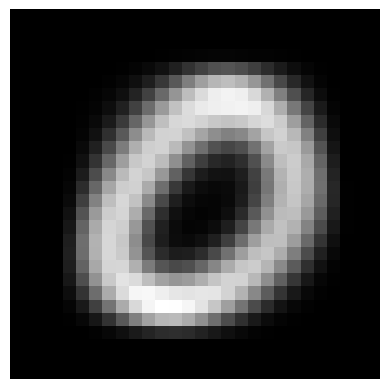

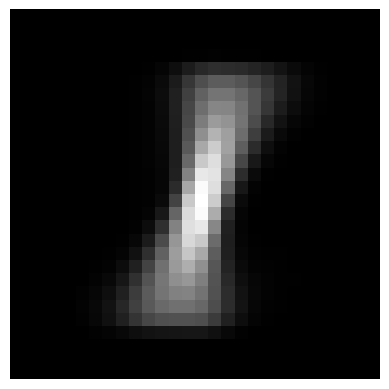

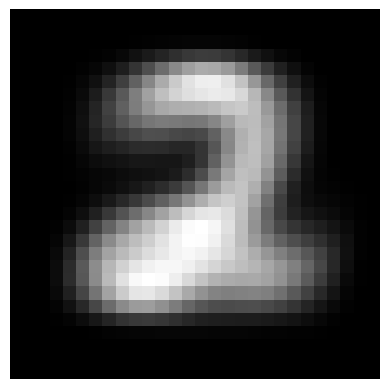

In [18]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])


## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [71]:
# Now test the performance of a predictor based on a subset of features
def test_model(mu, sigma, pi, tx, ty):
    # to do code here
    k = 10
    score = np.zeros((tx.shape[0] , k))
    for label in range(0,k):
        score[: , label] = np.log(pi[label]) + multivariate_normal.logpdf(tx, mean=mu[label], cov=sigma[label])
       
    predictions = np.argmax(score[:,:], axis=1)
    errors = np.sum(predictions != ty)
    return errors
    

In [52]:
errors = test_model(mu, sigma, pi, test_data, test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")
print("This is " + str(errors/100) + "% error rate")

Your model makes 1866 errors out of 10000
This is 18.66% error rate


##  choose C

- use cross validation and tunning to search about good c value

In [54]:
c = np.identity(784) * 0.2

In [56]:
from sklearn.model_selection import train_test_split

In [61]:
trainx , valx , trainy , valy = train_test_split(train_data,train_labels,stratify=train_labels)

In [ ]:
mu, sigma, pi = fit_generative_model(trainx, trainy)

In [104]:
# tunning for best c depend on small validation set

val_scores = []

c = np.arange(2820, 2840, 2)
for i in c:
    new_sigma = 0 
    new_sigma = ( np.identity(784) * i ) + sigma
    error_score = test_model(mu, new_sigma, pi, valx, valy) / 100 
    val_scores.append(error_score)
print(f"best validation score: {np.min(val_scores):.3}")
best_c = c[np.argmin(val_scores)]
print("best c:", best_c)


best validation score: 7.07
best c: 2824


In [105]:
val_scores

[7.08, 7.08, 7.07, 7.07, 7.07, 7.07, 7.07, 7.07, 7.07, 7.07]

In [110]:
# error in train
mu, sigma, pi = fit_generative_model(train_data, train_labels)
new_sigma = ( np.identity(784) * 2830 ) + sigma
error_score = test_model(mu, new_sigma, pi, train_data,train_labels) / 100 
print(error_score)

24.4


In [111]:
error_score = test_model(mu, new_sigma, pi, test_data,test_labels) / 100 
print(error_score)

4.28


## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?
- linera algebra error, get singular matrix, if we allow singlar the error rate is 18.66

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?
- the error rate increase , no

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?
- c = 2830 , 24.18 and 4.27 in the testset !

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

### what if using different c for every class ? and what this Cs ?

- i think we need only to change sigma by label

In [122]:
mu, sigma, pi = fit_generative_model(trainx, trainy)

In [127]:
# tunning for best c depend on small validation set
n_sigma = sigma.copy()
val_scores = {}

for ite in range(100) :
    # fast test, take random numbers for 100 times
    Cs = random.sample(range(2500, 3000 ), 10)
    i = 0 
    for c_label in Cs:
        n_sigma[i] = n_sigma[i] + ( np.identity(784) * c_label ) 
        i = i + 1
    error_score = test_model(mu, n_sigma, pi, valx, valy) / 100 
    val_scores[error_score] = Cs
  #  val_scores.append(error_score)
    
#print(f"best validation score: {np.min(val_scores):.3}")
#best_Cs = c[np.argmin(val_scores)]
#print("best c:", best_c)
print(val_scores)


{13.34: [2838, 2613, 2930, 2852, 2899, 2704, 2875, 2868, 2911, 2724], 12.15: [2758, 2717, 2901, 2841, 2772, 2834, 2556, 2947, 2852, 2993], 16.2: [2752, 2953, 2928, 2537, 2983, 2611, 2885, 2529, 2709, 2587], 14.25: [2619, 2903, 2849, 2754, 2822, 2617, 2912, 2731, 2523, 2974], 15.85: [2728, 2898, 2688, 2782, 2607, 2500, 2567, 2968, 2726, 2966], 27.33: [2732, 2868, 2980, 2772, 2800, 2505, 2663, 2879, 2788, 2513], 23.69: [2768, 2626, 2621, 2622, 2834, 2763, 2968, 2725, 2658, 2806], 26.29: [2984, 2730, 2711, 2811, 2929, 2763, 2535, 2752, 2971, 2985], 26.41: [2753, 2865, 2805, 2898, 2860, 2937, 2572, 2985, 2904, 2554], 32.11: [2984, 2662, 2642, 2791, 2876, 2549, 2787, 2687, 2559, 2904], 31.78: [2821, 2817, 2623, 2854, 2867, 2870, 2600, 2807, 2722, 2609], 40.7: [2943, 2575, 2737, 2918, 2876, 2700, 2549, 2781, 2873, 2855], 47.04: [2700, 2934, 2699, 2751, 2721, 2515, 2988, 2614, 2905, 2640], 50.12: [2808, 2556, 2923, 2662, 2955, 2802, 2664, 2810, 2859, 2620], 54.4: [2861, 2759, 2629, 2910, 2615

(10,)

In [114]:
sigma

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [113]:
new_sigma

array([[[2830.,    0.,    0., ...,    0.,    0.,    0.],
        [   0., 2830.,    0., ...,    0.,    0.,    0.],
        [   0.,    0., 2830., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ..., 2830.,    0.,    0.],
        [   0.,    0.,    0., ...,    0., 2830.,    0.],
        [   0.,    0.,    0., ...,    0.,    0., 2830.]],

       [[2830.,    0.,    0., ...,    0.,    0.,    0.],
        [   0., 2830.,    0., ...,    0.,    0.,    0.],
        [   0.,    0., 2830., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ..., 2830.,    0.,    0.],
        [   0.,    0.,    0., ...,    0., 2830.,    0.],
        [   0.,    0.,    0., ...,    0.,    0., 2830.]],

       [[2830.,    0.,    0., ...,    0.,    0.,    0.],
        [   0., 2830.,    0., ...,    0.,    0.,    0.],
        [   0.,    0., 2830., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ..., 2830.,    0.,    0.],
        [   0.,    0.,    0., ...,    0., 283